# Reading Data

In [1]:
import pandas as pd

real_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')

real_df['label'] = 1
fake_df['label'] = 0

df = pd.concat([real_df, fake_df], axis=0).reset_index(drop=True)

print(df.head())
print("Dataset shape:", df.shape)


                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
3  December 30, 2017       1  
4  December 29, 2017       1  
Dataset shape: (44898, 5)


# Pre-Processing:
# Removing (HTML Tags, stopwords, numbers and punctuation)
# Lowercasing
# Tokenization
# Limmitaization

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Keep important negations by removing them from stopwords
    custom_stopwords = stop_words - {'not', 'no', 'nor'}
    
    # Lowercase
    text = text.lower()
    
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize
    words = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in custom_stopwords and len(word) > 2]
    
    return " ".join(words)

df['clean_text'] = df['text'].apply(preprocess_text)

print("Preprocessing complete. Sample:")
print(df[['text', 'clean_text']].head())


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/tmp/ipykernel_13/3400567907.py:17: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go

Preprocessing complete. Sample:
                                                text  \
0  WASHINGTON (Reuters) - The head of a conservat...   
1  WASHINGTON (Reuters) - Transgender people will...   
2  WASHINGTON (Reuters) - The special counsel inv...   
3  WASHINGTON (Reuters) - Trump campaign adviser ...   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...   

                                          clean_text  
0  washington reuters head conservative republica...  
1  washington reuters transgender people allowed ...  
2  washington reuters special counsel investigati...  
3  washington reuters trump campaign adviser geor...  
4  seattlewashington reuters president donald tru...  


# Applying TF-IDF

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7
)

X = tfidf.fit_transform(df['clean_text'])

y = df['label'].to_numpy()

print("TF-IDF matrix shape:", X.shape)


TF-IDF matrix shape: (44898, 15000)


# Logistic Regression Model

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9890

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4650
           1       0.98      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



# SVM Model

In [5]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)


svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9959

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4650
           1       1.00      1.00      1.00      4330

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



# Comparing Accuracies and F1-Scores

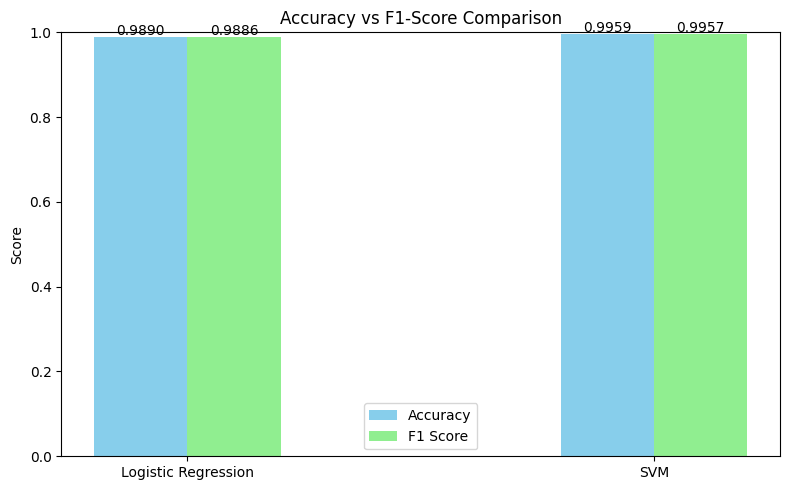

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

lr_f1 = f1_score(y_test, y_pred_lr)
svm_f1 = f1_score(y_test, y_pred_svm)

models = ['Logistic Regression', 'SVM']
accuracies = [lr_accuracy, svm_accuracy]
f1_scores = [lr_f1, svm_f1]

x = range(len(models))
width = 0.2 

plt.figure(figsize=(8,5))
plt.bar([i - width/2 for i in x], accuracies, width=width, label='Accuracy', color='skyblue')
plt.bar([i + width/2 for i in x], f1_scores, width=width, label='F1 Score', color='lightgreen')

plt.xticks(x, models)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Accuracy vs F1-Score Comparison")
plt.legend()

for i, acc in enumerate(accuracies):
    plt.text(i - width/2, acc + 0.005, f"{acc:.4f}", ha='center')
for i, f1 in enumerate(f1_scores):
    plt.text(i + width/2, f1 + 0.005, f"{f1:.4f}", ha='center')

plt.tight_layout()
plt.show()


# Visualizing using Word Cloud

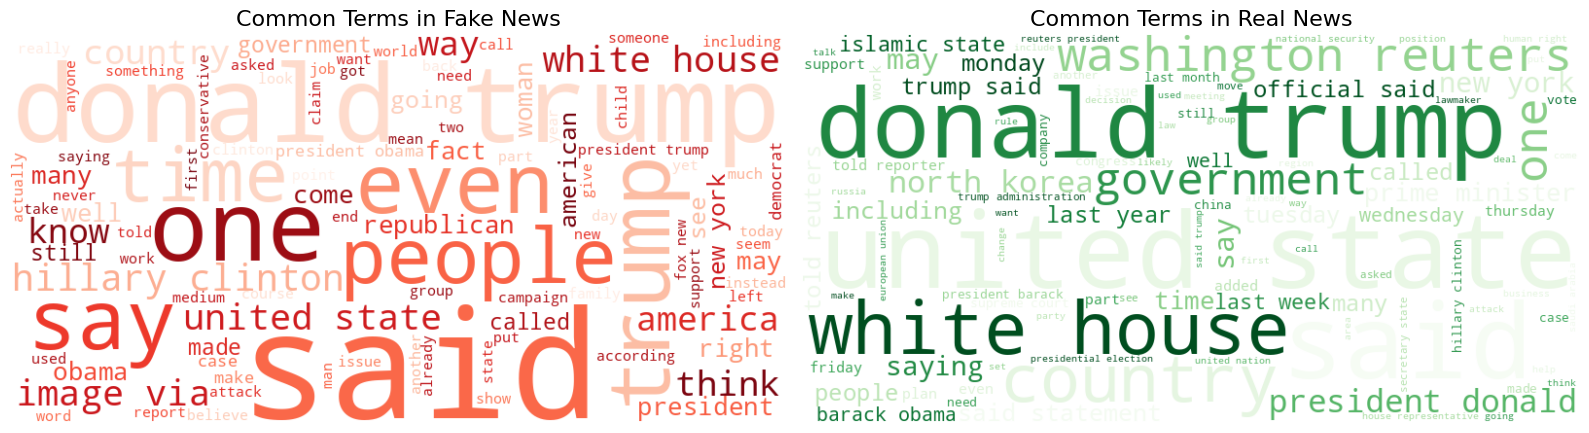

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate clean text for fake and real news
fake_text = " ".join(df.loc[df['label'] == 0, 'clean_text'])
real_text = " ".join(df.loc[df['label'] == 1, 'clean_text'])

# Generate word clouds
fake_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds',
                    max_words=100).generate(fake_text)
real_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens',
                    max_words=100).generate(real_text)

# Plot side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(fake_wc, interpolation='bilinear')
plt.title("Common Terms in Fake News", fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(real_wc, interpolation='bilinear')
plt.title("Common Terms in Real News", fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()
